In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)

In [5]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 3
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[3]},{0:[3],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=2)

In [6]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync.load_eeg(sub)
    
    for xdata,ydata in sync.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync.balance_labels(xdata,ydata)
        xdata,ydata = sync.average_trials(xdata,ydata)
        xdata,ydata = sync.group_data(xdata,ydata) # check if this is correct or should be group labels?
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results.
interp = decode_eeg.Interpreter(clfr,subtitle=f'color_to_ori_trialbin{trial_average}_')
# interp.save_results()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [18]:
interp = decode_eeg.Interpreter()
# interp.load_results('binning_single_feat_set_size_20200423_1355.pickle')

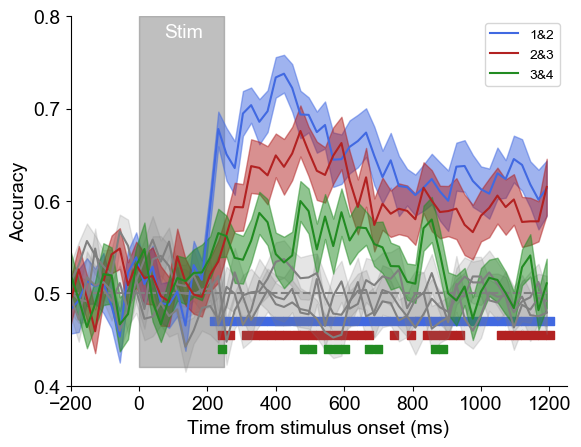

In [11]:
interp.plot_acc_subset(subset_list=['1&2','2&3','3&4'],
                       ylim=[.4,.8], chance=.5, sig_ys=[.47,.455,.44], chance_text_y=.25,
                       significance_testing=True,savefig=False)

In [ ]:
import winsound
winsound.PlaySound("SystemExit",winsound.SND_ALIAS)